<a href="https://colab.research.google.com/github/AmmarMalik93/ICT_UiB_2023/blob/main/Captum_Tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Titanic Data Analysis using Captum**

**Import/install necessary libraries**

In [ ]:
# Initial imports
import numpy as np

import torch

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

In [ ]:
!pip install captum

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

**Load titanic data**


In [ ]:
url = 'https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv'
titanic_data = pd.read_csv(url)

In [ ]:
titanic_data

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.50,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.50,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.00,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


**Preprocess the data**: Convert categorical features such as gender, location of embarcation, and passenger class into one-hot encodings. Remove features such as name, and fill missing values in age and fare with the average values.

In [ ]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1)
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)

In [ ]:
titanic_data

,survived,age,sibsp,parch,fare,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,1,29.000000,0,0,211.3375,1,0,0,0,1,1,0,0
1,1,0.920000,1,2,151.5500,0,1,0,0,1,1,0,0
2,0,2.000000,1,2,151.5500,1,0,0,0,1,1,0,0
3,0,30.000000,1,2,151.5500,0,1,0,0,1,1,0,0
4,0,25.000000,1,2,151.5500,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,14.500000,1,0,14.4542,1,0,1,0,0,0,0,1
1305,0,29.881138,1,0,14.4542,1,0,1,0,0,0,0,1
1306,0,26.500000,0,0,7.2250,0,1,1,0,0,0,0,1
1307,0,27.000000,0,0,7.2250,0,1,1,0,0,0,0,1


**Split data into train-test sets**

In [ ]:
# Set random seed for reproducibility.
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

**Define neural network model**

In [ ]:
import torch
import torch.nn as nn
torch.manual_seed(1)  # Set seed for reproducibility.
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In [ ]:
net = TitanicSimpleNNModel()
print(net)

TitanicSimpleNNModel(
  (linear1): Linear(in_features=12, out_features=12, bias=True)
  (sigmoid1): Sigmoid()
  (linear2): Linear(in_features=12, out_features=8, bias=True)
  (sigmoid2): Sigmoid()
  (linear3): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
num_epochs = 200

optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)
for epoch in range(num_epochs):
    output = net(input_tensor)
    loss = criterion(output, label_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))


Epoch 1/200 => Loss: 0.70
Epoch 11/200 => Loss: 0.62
Epoch 21/200 => Loss: 0.55
Epoch 31/200 => Loss: 0.51
Epoch 41/200 => Loss: 0.50
Epoch 51/200 => Loss: 0.50
Epoch 61/200 => Loss: 0.49
Epoch 71/200 => Loss: 0.49
Epoch 81/200 => Loss: 0.48
Epoch 91/200 => Loss: 0.49
Epoch 101/200 => Loss: 0.48
Epoch 111/200 => Loss: 0.48
Epoch 121/200 => Loss: 0.48
Epoch 131/200 => Loss: 0.48
Epoch 141/200 => Loss: 0.48
Epoch 151/200 => Loss: 0.47
Epoch 161/200 => Loss: 0.47
Epoch 171/200 => Loss: 0.47
Epoch 181/200 => Loss: 0.47
Epoch 191/200 => Loss: 0.47


**Model performance on train/test sets**

In [ ]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8427947598253275


In [ ]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.816793893129771


**Which of the features were actually important to the model to reach this decision?**

- Feature Attribution
- Integrated Gradients

In [ ]:
ig = IntegratedGradients(net)

In [ ]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

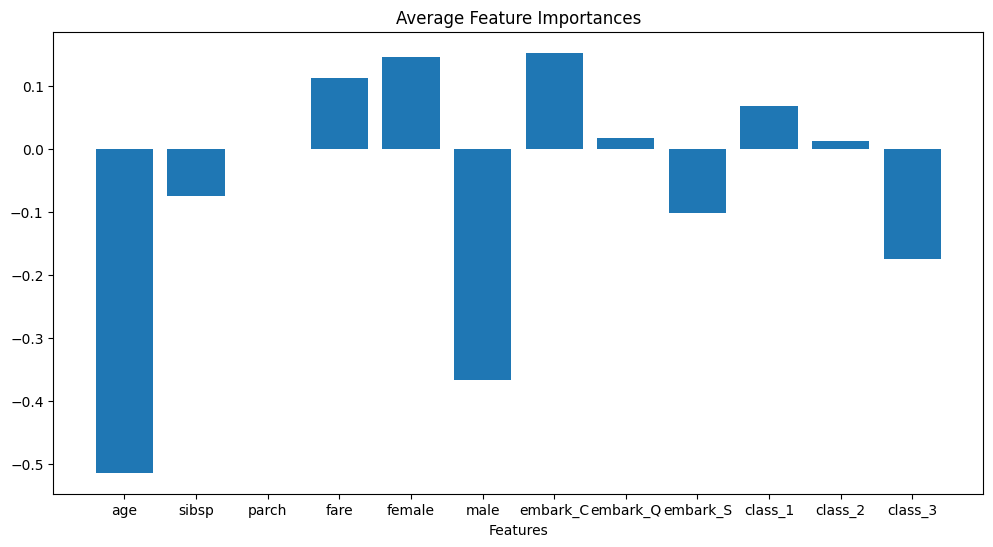

In [ ]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    # print(title)
    # for i in range(len(feature_names)):
        # print(feature_names[i], ": ", '%.3f'%(importances[i]))
  x_pos = (np.arange(len(feature_names)))
  if plot:
      plt.figure(figsize=(12,6))
      plt.bar(x_pos, importances, align='center')
      plt.xticks(x_pos, feature_names, wrap=True)
      plt.xlabel(axis_title)
      plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

**How the different neurons in each layer work together to reach the prediction**:

- Layer Attribution
- Layer Conductance

In [ ]:
cond = LayerConductance(net, net.sigmoid1)

In [ ]:
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()

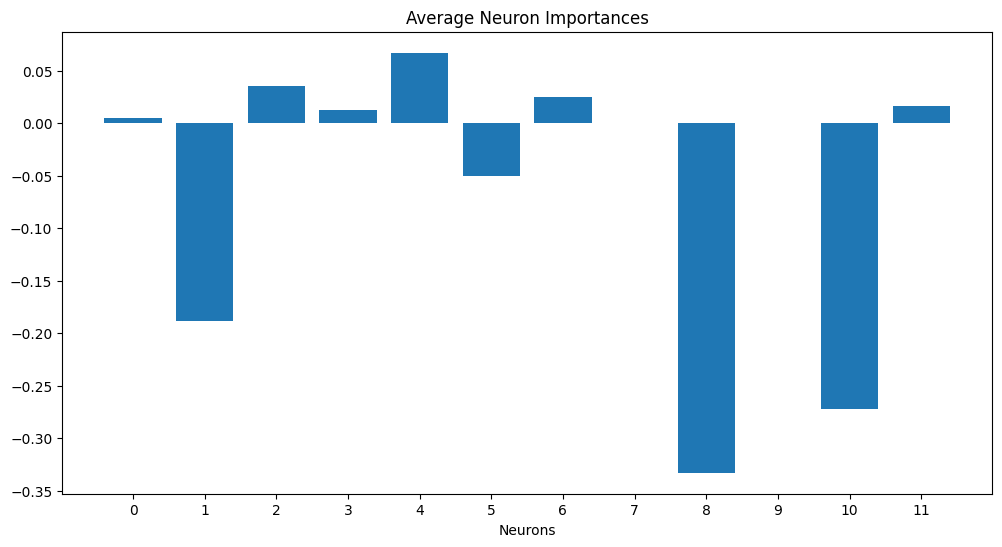

In [ ]:
visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

**What each of these important neurons are looking at in the input?**:
- Neuron Attribution
- Neuron Conductance

In [ ]:
neuron_cond = NeuronConductance(net, net.sigmoid1)

In [ ]:
neuron_cond_vals_10 = neuron_cond.attribute(test_input_tensor, neuron_selector=10, target=1)

In [ ]:
neuron_cond_vals_0 = neuron_cond.attribute(test_input_tensor, neuron_selector=0, target=1)

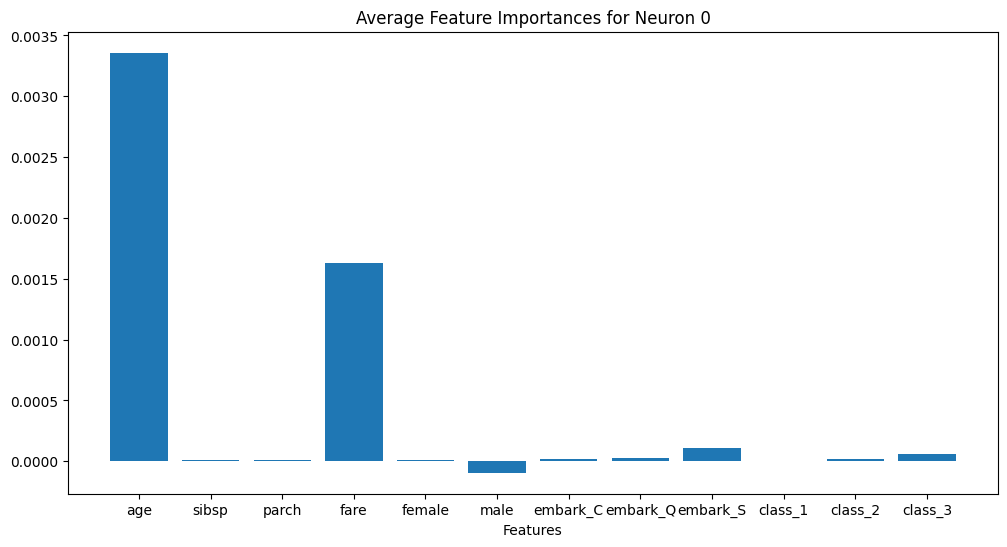

In [ ]:
visualize_importances(feature_names, neuron_cond_vals_0.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0")

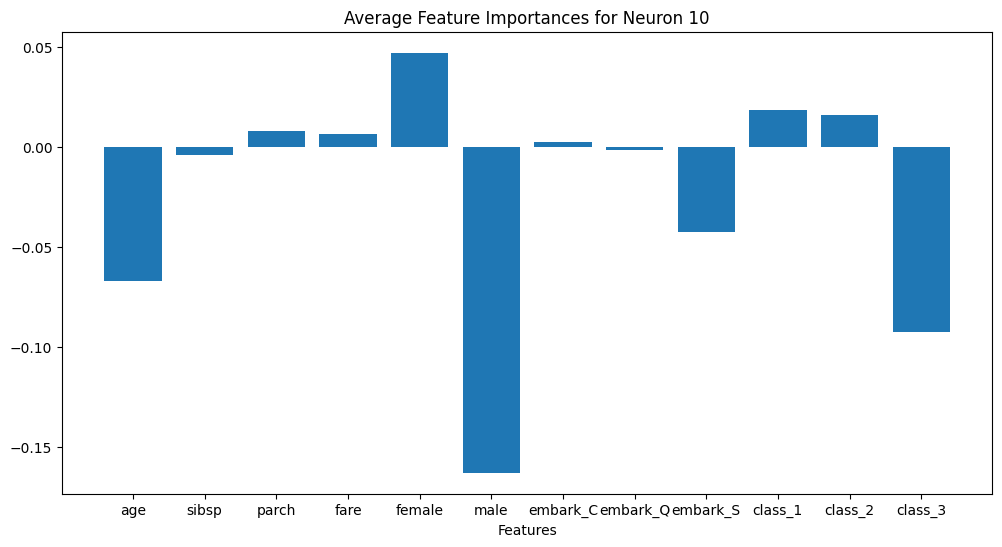

In [ ]:
visualize_importances(feature_names, neuron_cond_vals_10.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 10")